# Remove lateral x-rays

In [2]:
# Import necessary libraries
from fastai.basics import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.all import *

from fastai.metrics import *
from fastai.callback.wandb import *

import numpy as np
from PIL import Image

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

import os
import cv2
import shutil

import matplotlib.image as mpimg
from matplotlib import rcParams

from random import sample

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 16 ,8
import os

In [2]:
def label_func_hospital(fname):
    fname = str(fname)
    if "/chexpert/" in fname:
        return "chexpert"
    elif "/iu/" in fname:
        return "iu"
    elif "/nih/" in fname:
        return "nih"
    else:
        raise Exception("Invalid file path")
        
from PIL import Image, ImageOps

In [8]:
def label_func_pneumonia(fname):
    fname = str(fname)
    if "/NORMAL/" in fname:
        return "NORMAL"
    elif "/PNEUMONIA/" in fname:
        return "PNEUMONIA"
    else:
        raise Exception("Invalid file path")

# Checking Imgs between datasets

In [22]:
in_path = Path("/scratch/rc4499/masked/hospital_systems")
none_path = in_path/"none"/"val"
raw_path = in_path/"raw"/"val"
convex_path = in_path/"convex_hull"/"val"

none_imgs = get_image_files(none_path)
raw_imgs = get_image_files(raw_path)
convex_imgs = get_image_files(convex_path)
none_imgs.sort()
raw_imgs.sort()
convex_imgs.sort()
# my_sample = sample(new_mask_fnames, 20)

In [23]:
combined = list(zip(none_imgs, raw_imgs, convex_imgs))

In [6]:
print(none_imgs[10000], raw_imgs[10000])

/scratch/rc4499/masked/hospital_systems/none/val/chexpert/patient24154_study2_view1_frontal.jpg /scratch/rc4499/masked/hospital_systems/raw/val/chexpert/patient24154_study2_view1_frontal.jpg


chexpert /scratch/rc4499/masked/hospital_systems/none/val/chexpert/patient46322_study1_view1_frontal.jpg
chexpert /scratch/rc4499/masked/hospital_systems/none/val/chexpert/patient33251_study5_view1_frontal.jpg
chexpert /scratch/rc4499/masked/hospital_systems/none/val/chexpert/patient42535_study6_view1_frontal.jpg
chexpert /scratch/rc4499/masked/hospital_systems/none/val/chexpert/patient02318_study2_view2_lateral.jpg
nih /scratch/rc4499/masked/hospital_systems/none/val/nih/00002423_001.png


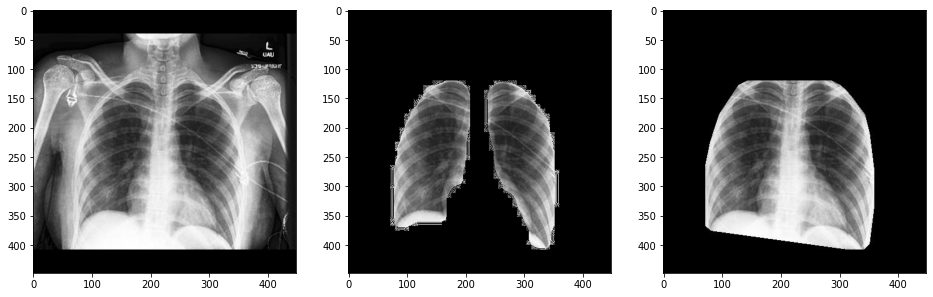

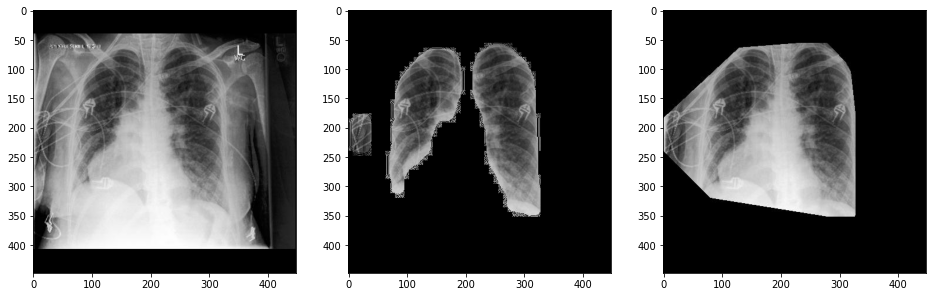

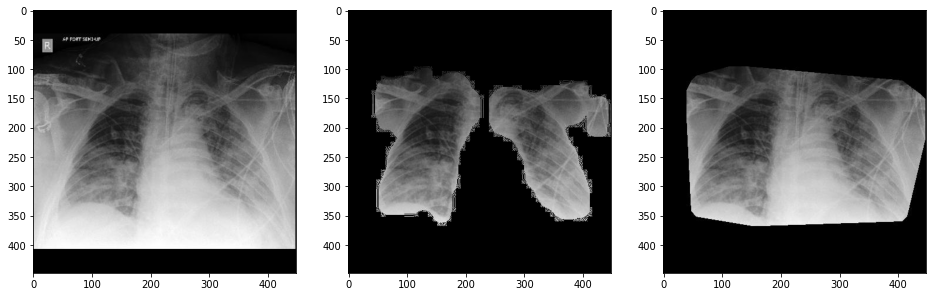

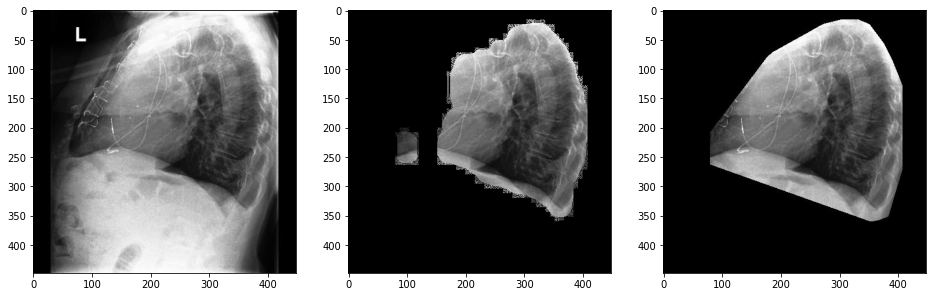

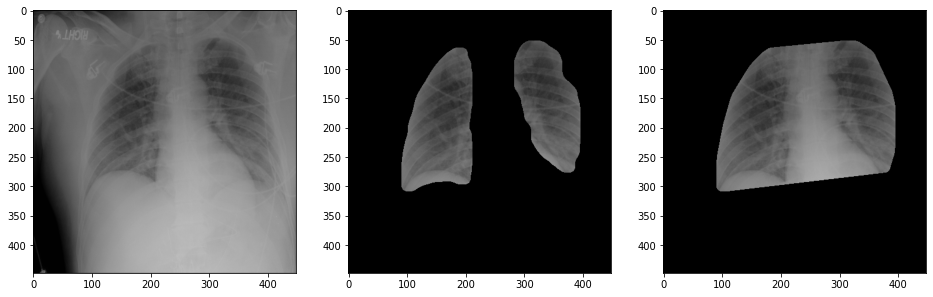

In [30]:
my_sample = sample(combined, 5)

for fname in my_sample:
    # read images
    print(label_func_hospital(fname[0]), fname[0])
    # display images
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(mpimg.imread(fname[0]))
    ax[1].imshow(mpimg.imread(fname[1]))
    ax[2].imshow(mpimg.imread(fname[2]))
    # ax[1].imshow(img_C)
    # ax[2].imshow(orig, cmap="gray")
    # ax[3].imshow(clean, cmap="gray")
    # ax[4].imshow(clean_close, cmap="gray")

In [8]:
in_path = Path("/scratch/rc4499/hospital_systems")
img_path = in_path/"imgs"
print(img_path.ls())
img_fnames = get_image_files(img_path)

out_path = Path("/scratch/rc4499/hospital_systems_clean")
out_img_path = out_path/"imgs"

[Path('/scratch/rc4499/hospital_systems/imgs/chexpert'), Path('/scratch/rc4499/hospital_systems/imgs/nih'), Path('/scratch/rc4499/hospital_systems/imgs/iu')]


# Removing Laterals

In [6]:
base_path = Path("/scratch/rc4499/hospital_systems_clean")
classes = ["chexpert"]

imgs = [(x, get_image_files(base_path/"imgs"/x)) for x in classes]

In [7]:
def is_lateral(img_path, c):
    if c == "chexpert":
        return "_lateral.jpg" in img_path.name
    if c == "nih":
        return False

In [8]:
for c in imgs:
    img_list = c[1]
    
    for img in tqdm(img_list):
        # print(f"Checking img {img}")
        if is_lateral(img, c[0]):
            # print(f"Deleting image {img}")
            os.remove(str(img))

  0%|          | 0/223648 [00:00<?, ?it/s]

# Remove Bad Segmentation Masks

In [11]:
# Load the raw dataset and gt masks
root_path = Path("/scratch/rc4499/chexpert_pn_clean")
img_path = root_path/"imgs"
mask_path = root_path/"masks_smooth"

img_fnames = get_image_files(img_path)

In [12]:
len(img_fnames)

12280

In [5]:
def get_mask_path(dataset_type, fpath):
    if dataset_type == "pneumonia":
        return mask_path/fpath.name
    if dataset_type == "hospital_systems":
        return mask_path/fpath.name

def create_instances(img_fnms, dataset_type):
    result = []
    for fname in tqdm(img_fnms, desc="Creating instances"):
        mask_name = get_mask_path(dataset_type, fname)
        result.append((fname, mask_name))
        
    return result

In [6]:
instances = create_instances(img_fnames, "hospital_systems")

len(instances)

Creating instances:   0%|          | 0/14228 [00:00<?, ?it/s]

14228

In [8]:
# Loop through all files now and delete the bad masks
import random

# rand_inst = sample(instances, 5000)
rand_inst = None

In [10]:
inst_before = {"NORMAL":0, "PNEUMONIA":0}
inst_delete = {"NORMAL":0, "PNEUMONIA":0}
TEST=False
thresh = 0.2
    
for inst in tqdm(instances):
    inst_before[label_func_pneumonia(inst[0])] += 1
    mask = np.asarray(PILMask.create(inst[1]))
    if mask.max() == 0:
        print(f"Removing mask with no items = {inst[0]}")
        # Delete file
        if not TEST:
            os.remove(str(inst[0]))
        inst_delete[label_func_pneumonia(inst[0])] += 1
        continue

    mask = mask / mask.max()
    prop = mask.sum() / mask.size
    if prop < thresh:
        # Delete file
        if not TEST:
            os.remove(str(inst[0]))
        inst_delete[label_func_pneumonia(inst[0])] += 1
    
print(inst_before)
print(inst_delete)

  0%|          | 0/14228 [00:00<?, ?it/s]

Removing mask with no items = /scratch/rc4499/chexpert_pn_clean/imgs/PNEUMONIA/patient20683_study2_view1_frontal.jpg
Removing mask with no items = /scratch/rc4499/chexpert_pn_clean/imgs/PNEUMONIA/patient13077_study4_view2_frontal.jpg
Removing mask with no items = /scratch/rc4499/chexpert_pn_clean/imgs/PNEUMONIA/patient07569_study2_view1_frontal.jpg
Removing mask with no items = /scratch/rc4499/chexpert_pn_clean/imgs/NORMAL/patient02885_study1_view1_frontal.jpg
Removing mask with no items = /scratch/rc4499/chexpert_pn_clean/imgs/NORMAL/patient41928_study1_view1_frontal.jpg
Removing mask with no items = /scratch/rc4499/chexpert_pn_clean/imgs/NORMAL/patient34612_study2_view1_frontal.jpg
{'NORMAL': 9553, 'PNEUMONIA': 4675}
{'NORMAL': 1003, 'PNEUMONIA': 945}


In [16]:
my_sample = sample(instances, 5)

55368.1843137255 0.27586985966261507
52023.490196078434 0.2592050492071829
45536.38039215686 0.22688327284038615
42851.84705882353 0.21350768823154262
47481.80392156864 0.23657627113345342


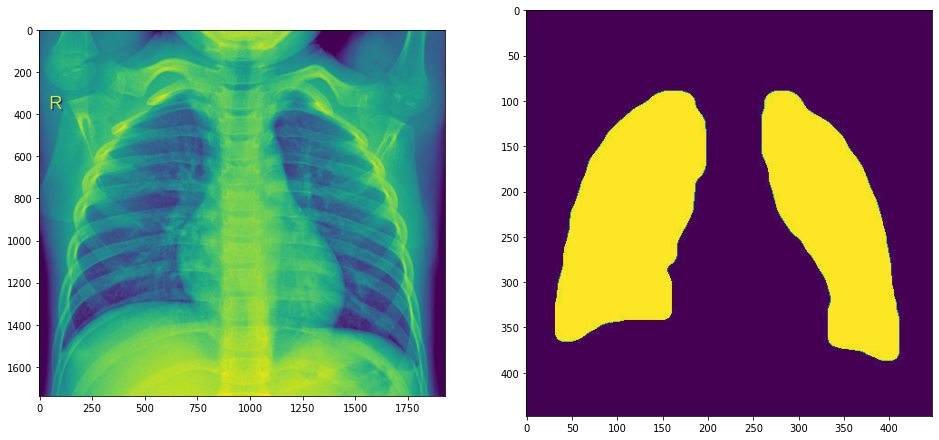

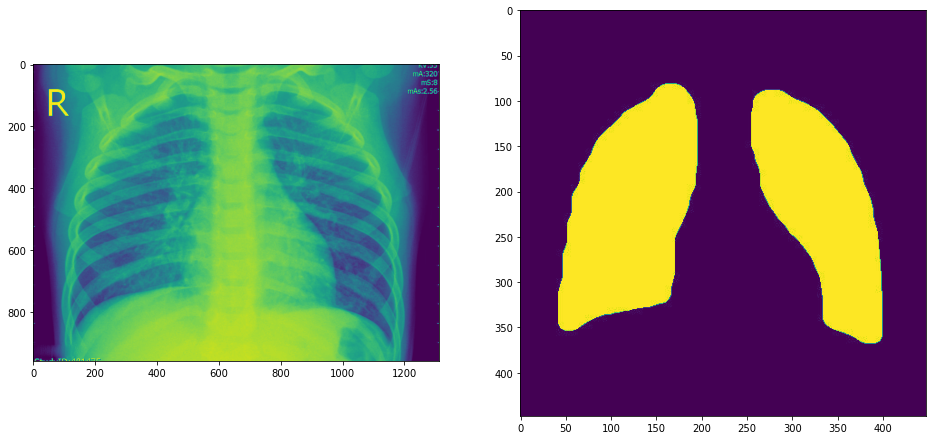

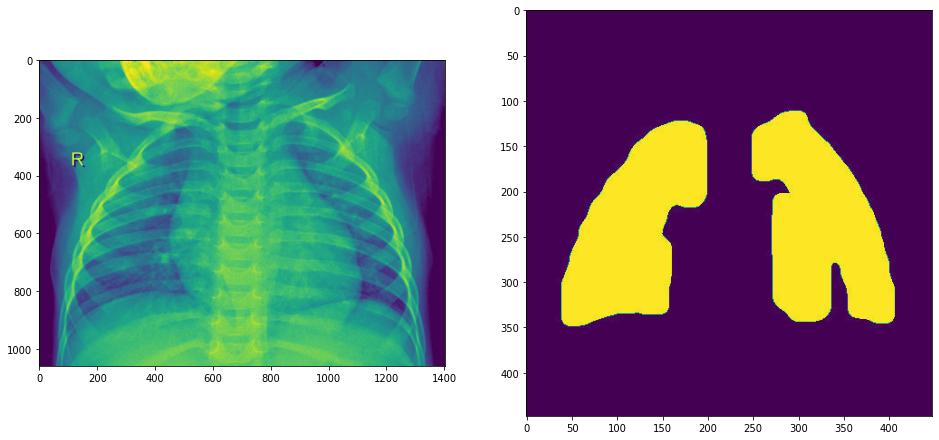

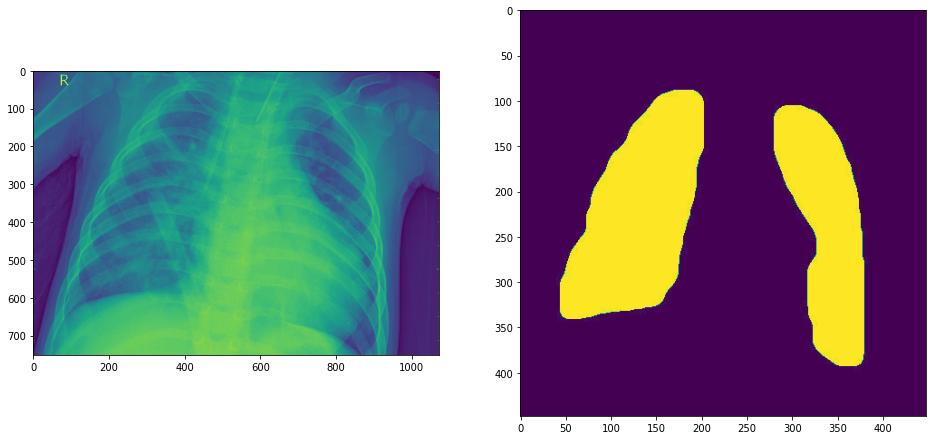

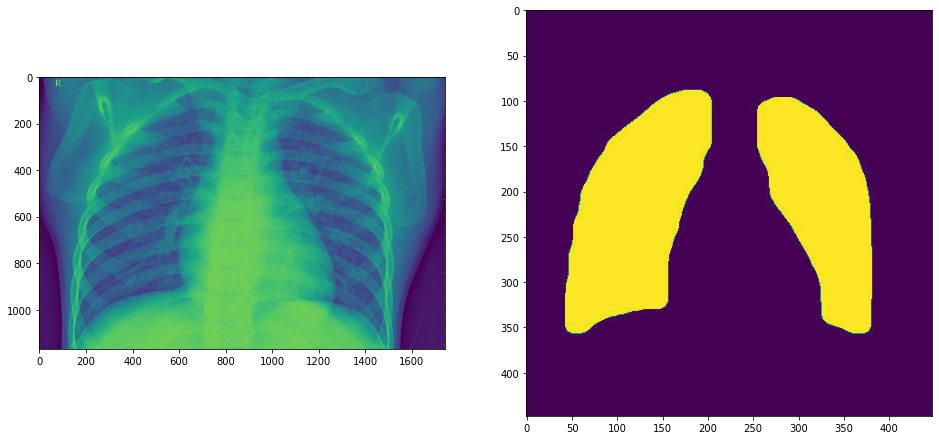

In [17]:
for s in my_sample:
    fig, ax = plt.subplots(1,2)
    mask = np.asarray(PILMask.create(s[1]))
    mask = mask / mask.max()
    print(mask.sum(), mask.sum() / mask.size)
    ax[0].imshow(mpimg.imread(s[0]))
    ax[1].imshow(mpimg.imread(s[1]))
    